In [275]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import os
import matplotlib.pyplot as plt
from matplotlib import pylab
import emoji
import re
import contractions
from bs4 import BeautifulSoup
import unicodedata

<IPython.core.display.Javascript object>

In [276]:
%config IPCompleter.greedy=True
%matplotlib inline
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [277]:
# Constants
curr_dir = ".."
train_file = os.path.join(curr_dir, "dataset", "train.csv")
test_file = os.path.join(curr_dir, "dataset", "test.csv")

<IPython.core.display.Javascript object>

In [278]:
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (16, 5),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set_theme(style="darkgrid")

<IPython.core.display.Javascript object>

In [279]:
df = pd.read_csv(train_file)
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

<IPython.core.display.Javascript object>

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<IPython.core.display.Javascript object>

In [281]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<IPython.core.display.Javascript object>

In [282]:
def plotBarGraph(data, labelx, labely, title, switch_axis=False):
    y = data.index.tolist()
    x = data.tolist()
    if switch_axis:
        x = data.index.tolist()
        y = data.tolist()
    sns.barplot(y=y, x=x)
    plt.title(title)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.show()

<IPython.core.display.Javascript object>

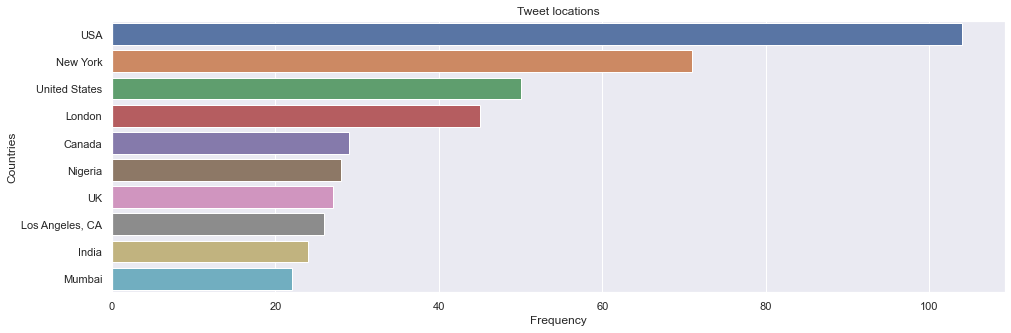

<IPython.core.display.Javascript object>

In [283]:
locations_map = df.location.value_counts().sort_values(ascending=False)[:10]
plotBarGraph(locations_map, "Frequency", "Countries", "Tweet locations")

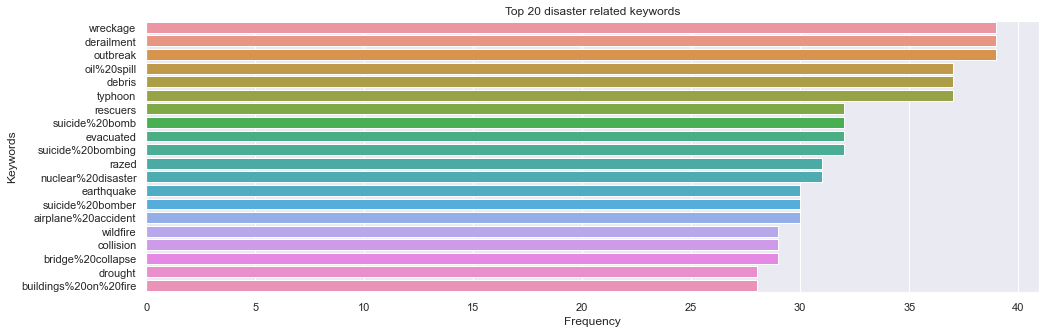

<IPython.core.display.Javascript object>

In [284]:
# Top 20 Disaster related Keywords
keywords_map = (
    df.keyword.loc[df.target == 1].value_counts().sort_values(ascending=False)[:20]
)
plotBarGraph(keywords_map, "Frequency", "Keywords", "Top 20 disaster related keywords")

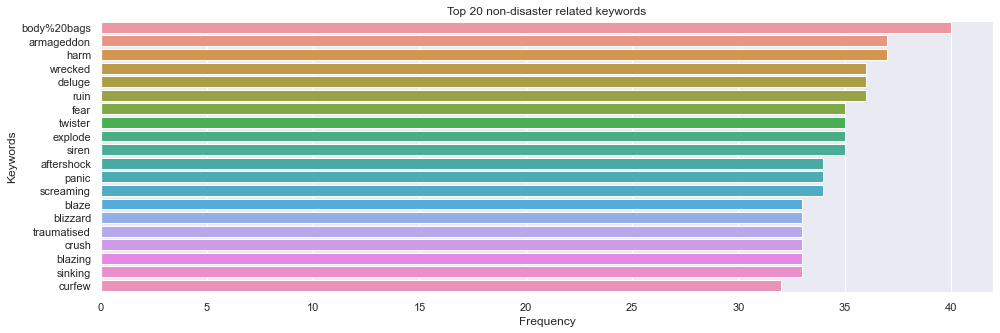

<IPython.core.display.Javascript object>

In [285]:
# Top 20 Non-Disaster related Keywords
keywords_non_disaster_map = df.keyword.loc[df.target == 0].value_counts(
    ascending=False
)[:20]
plotBarGraph(
    keywords_non_disaster_map,
    "Frequency",
    "Keywords",
    "Top 20 non-disaster related keywords",
)

In [286]:
print(
    "In the graphs(Top 20 disaster keywords and non-disaster keywords) above\n we see that disaster keywords are natural or artificial calamilites.\nWhile non-disaster keywords are too generalized keywords and not sufficient to describe a disaster."
)

In the graphs(Top 20 disaster keywords and non-disaster keywords) above
 we see that disaster keywords are natural or artificial calamilites.
While non-disaster keywords are too generalized keywords and not sufficient to describe a disaster.


<IPython.core.display.Javascript object>

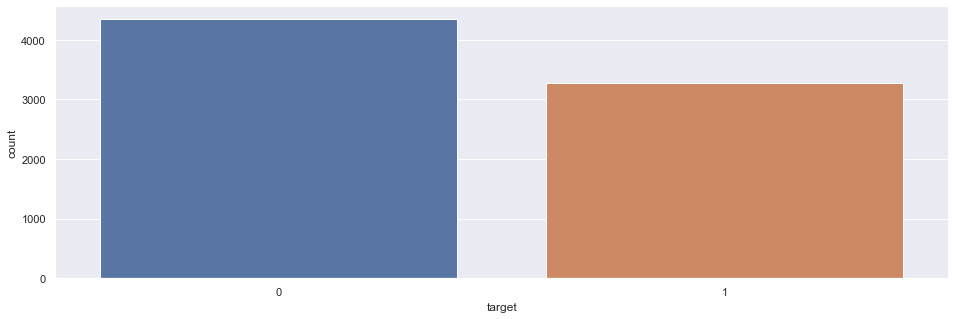

<IPython.core.display.Javascript object>

In [287]:
sns.countplot(x="target", data=df)
plt.show()

False    7503
True      110
Name: text, dtype: int64


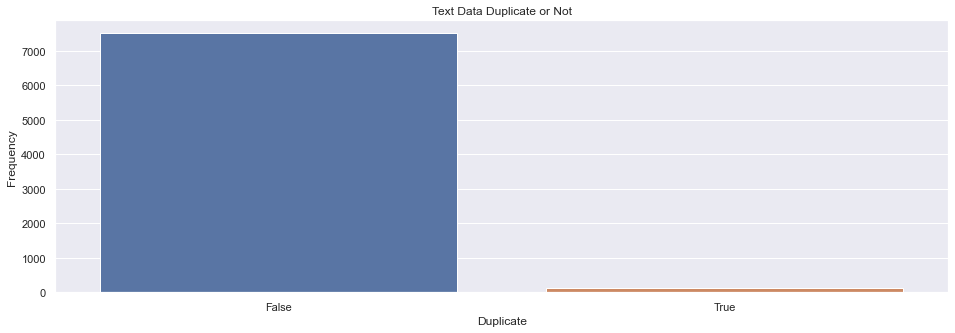

<IPython.core.display.Javascript object>

In [288]:
# Removing Duplicate Text Data
text_data_duplicate_map = df.text.duplicated().value_counts()
print(text_data_duplicate_map)
plotBarGraph(
    text_data_duplicate_map,
    "Duplicate",
    "Frequency",
    "Text Data Duplicate or Not",
    switch_axis=True,
)

In [289]:
print("Original dataframe shape: ", df.shape)
df.drop_duplicates(subset="text", keep="first", inplace=True)
print("Dropping duplicate rows and keeping original value shape: ", df.shape)
df.text.duplicated().value_counts()

Original dataframe shape:  (7613, 5)
Dropping duplicate rows and keeping original value shape:  (7503, 5)


False    7503
Name: text, dtype: int64

<IPython.core.display.Javascript object>

In [290]:
def search_text_data(query, column="text"):
    return df[df[column].str.contains(query)][column]


print(search_text_data("volcano")[:5])

1368    @POTUS Would you please explain what you are g...
3041    #SCSeEstaPreparando Light mag. 4.4 earthquake ...
4714    The sunset looked like an erupting volcano ......
6771    Maybe that's what happens when a tornado meets...
7126    Jetstar and Virgin forced to cancel Bali fligh...
Name: text, dtype: object


<IPython.core.display.Javascript object>

In [291]:
# Cleaning Text Data
def lower_case_data(data=""):
    data = data.lower()
    return data


df["clean_text"] = df["text"].apply(lower_case_data)
df["clean_text"]

0       our deeds are the reason of this #earthquake m...
1                  forest fire near la ronge sask. canada
2       all residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       just got sent this photo from ruby #alaska as ...
                              ...                        
7604    #worldnews fallen powerlines on g:link tram: u...
7605    on the flip side i'm at walmart and there is a...
7606    suicide bomber kills 15 in saudi security site...
7608    two giant cranes holding a bridge collapse int...
7612    the latest: more homes razed by northern calif...
Name: clean_text, Length: 7503, dtype: object

<IPython.core.display.Javascript object>

In [292]:
# Handle Emojis
def sentences_with_emojis(id_texts):
    sentences = []
    indeces = id_texts[0]
    texts = id_texts[1]
    for index, sentence in zip(indeces, texts):
        has_emoji = bool(emoji.get_emoji_regexp().search(sentence))
        if has_emoji:
            sentences.append((index, sentence))
    if len(sentences) == 0:
        return "Sentences are clean and don't have emojis!"
    else:
        return sentences


for emoji_tuple in sentences_with_emojis((df.index, df.clean_text)):
    print(emoji_tuple)

# Source: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def clean_emojis(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = " ".join(
        [str for str in text.split() if not any(i in str for i in emoji_list)]
    )
    return clean_text

(2171, 'how missing jet\x89ûªs debris could have floated to rì©union - the new york times http://t.co/pnnunrnqja')
(2172, 'rì©union debris is almost surely from flight 370 officials say - new york times http://t.co/gyqlaoz3l2')
(2173, 'rì©union debris is almost surely from flight 370 officials say - new york times http://t.co/vfbw3nyo9l')
(2179, '#love #food #fun malaysian prime minister najib razak confirmed that the aircraft debris found on rì©union isla...  http://t.co/fk1l4nozig')
(3479, 'exploring new worlds: three moments of an explosion by china miì©ville http://t.co/otrwz1t9sp http://t.co/xvlkfcvfx5')
(4390, "@ladyfleur the example i used is even worse in that it's a cafì© trying to market itself w/hashtag hijacking.")
(7127, "nside a dragon's belly. or an ice cave under\na volcano in kamchatka | photography by\nå©daniel korzhonov\nhttp://t.co/8t36hwgoqd")
(7514, '#science now that a piece of wreckage from flight mh370 has been confirmed on rì©union island is it possible t...  

<IPython.core.display.Javascript object>

In [293]:
# Clean Emojis
df["clean_text"] = df["clean_text"].apply(clean_emojis)
sentences_with_emojis((df.index, df.clean_text))

"Sentences are clean and don't have emojis!"

<IPython.core.display.Javascript object>

In [294]:
# Clean urls
def clean_urls(text):
    text = re.sub(r"https?://\S+", "", text)
    return text


print(
    "There are",
    len(search_text_data("https", "clean_text").tolist()),
    "sentences with urls",
)
df["clean_text"] = df["clean_text"].apply(clean_urls)
print(
    "There are",
    len(search_text_data("https", "clean_text").tolist()),
    "sentences with urls",
)

There are 404 sentences with urls
There are 0 sentences with urls


<IPython.core.display.Javascript object>

In [295]:
# Expand Contractions
df["clean_text"] = df["clean_text"].apply(contractions.fix)

<IPython.core.display.Javascript object>

In [296]:
# Remove all sorts of special characters and punctuations.
def removePunc(text):
    sentence = []
    for s in text:
        if s == " ":
            sentence.append(s)
        if s.isalnum():
            sentence.append(s)
    return "".join(sentence)


df["clean_text"] = df["clean_text"].apply(removePunc)

<IPython.core.display.Javascript object>

In [297]:
# Check any html text in df.text (not cleaned yet) column
def checkHtml(text):
    return bool(BeautifulSoup(text, "html.parser").find())


html_sentence_map = df["text"].apply(checkHtml).tolist()
if not any(html_sentence_map):
    print("No text containing html found!")
else:
    print("There is some html text!")

No text containing html found!


<IPython.core.display.Javascript object>

In [300]:
# Remove accented text
def remove_accented_chars(text):
    new_text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )
    return new_text


print("---------------Texts after removing accented characters---------------\n")
print("Before:", df.clean_text[2171])
df["clean_text"] = df["clean_text"].apply(remove_accented_chars)
print("After:", df.clean_text[2171])

---------------Texts after removing accented characters---------------

Before: how missing jetûªs debris could have floated to  the new york times 
After: how missing jetuas debris could have floated to  the new york times 


<IPython.core.display.Javascript object>